<a href="https://colab.research.google.com/github/mayurinegi/churn-analysis-dataset/blob/main/230173266_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost

import relevant libraries

In [2]:
!pip install seaborn


In [ ]:
!pip install catboost
import catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.6 MB/s eta 0:00:00


mount google drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import seaborn as sns
!pip install sidetable
import sidetable as stb
from datetime import datetime
import statistics
import datetime as dt


import matplotlib.pyplot as plt
def highlight_nans(val):
    color = 'red' if pd.isna(val) else ''
    return f'background-color: {color}'
from IPython.display import clear_output
clear_output()

# execution time
from timeit import default_timer as timer
from datetime import timedelta

# silence warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# increase column width
pd.set_option('display.max_colwidth', 100)

read the test and train file


In [6]:
trainset = pd.read_csv('/content/drive/My Drive/combined_train.csv')
testset = pd.read_csv('/content/drive/My Drive/combined_test.csv')


In [ ]:
view top rows of trainset

In [7]:
trainset.head()

,payment_method_id,actual_amount_paid,is_cancel,days_until_expiration,partial_play_ratio,avg_song_duration,skip_ratio,retention_time,engagement_score,plan_type_monthly,is_churn
0,41.0,-1.064783,0,31,2.126296,-1.173139,2.194036,-1.096834,-0.653578,1,0
1,41.0,0.604152,0,31,-0.137905,0.666371,0.022058,0.598651,1.270091,1,0
2,41.0,-0.063422,0,151,1.172460,-0.493013,1.273913,-0.241789,-0.928649,1,1
3,41.0,-1.064783,0,31,0.824094,0.023382,0.912384,0.050172,-0.166346,1,0
4,15.0,1.638892,0,244,0.092741,0.494447,0.263221,0.457508,0.692561,0,1


In [ ]:
view top rows of testset

In [8]:
testset.head()

,payment_method_id,actual_amount_paid,is_cancel,days_until_expiration,partial_play_ratio,avg_song_duration,skip_ratio,retention_time,engagement_score,is_churn
0,41.0,-1.266986,0,31,1.758234,-0.407201,1.946731,-0.723275,-0.769335,0
1,41.0,-1.266986,0,31,0.630795,0.171794,0.816805,0.098167,-0.378447,0
2,33.0,0.537046,0,30,2.238776,-1.022413,2.314496,-1.155832,-0.815635,0
3,39.0,0.537046,0,33,-0.463570,0.893834,-0.335590,0.754031,-0.207360,0
4,39.0,0.537046,0,33,-0.306210,0.332976,-0.254218,0.453273,-0.748618,0


remove payment_method_id as it is not needed for modelling

In [9]:
trainset = trainset.drop('payment_method_id', axis=1)

In [10]:
testset = testset.drop('payment_method_id', axis=1)

limitations Interpretability: The downside of keeping payment_method_id is that without understanding what each ID represents, interpreting the model’s output could be challenging. It might be hard to derive actionable insights or explain the results.

In [11]:
trainset.head()

,actual_amount_paid,is_cancel,days_until_expiration,partial_play_ratio,avg_song_duration,skip_ratio,retention_time,engagement_score,plan_type_monthly,is_churn
0,-1.064783,0,31,2.126296,-1.173139,2.194036,-1.096834,-0.653578,1,0
1,0.604152,0,31,-0.137905,0.666371,0.022058,0.598651,1.270091,1,0
2,-0.063422,0,151,1.172460,-0.493013,1.273913,-0.241789,-0.928649,1,1
3,-1.064783,0,31,0.824094,0.023382,0.912384,0.050172,-0.166346,1,0
4,1.638892,0,244,0.092741,0.494447,0.263221,0.457508,0.692561,0,1


In [12]:
testset.head()

,actual_amount_paid,is_cancel,days_until_expiration,partial_play_ratio,avg_song_duration,skip_ratio,retention_time,engagement_score,is_churn
0,-1.266986,0,31,1.758234,-0.407201,1.946731,-0.723275,-0.769335,0
1,-1.266986,0,31,0.630795,0.171794,0.816805,0.098167,-0.378447,0
2,0.537046,0,30,2.238776,-1.022413,2.314496,-1.155832,-0.815635,0
3,0.537046,0,33,-0.463570,0.893834,-0.335590,0.754031,-0.207360,0
4,0.537046,0,33,-0.306210,0.332976,-0.254218,0.453273,-0.748618,0


is_churn ratio in train set


In [15]:
trainset['is_churn'].value_counts(normalize=True)

,proportion
is_churn,
0,0.926006
1,0.073994


is_churn ratio test set


In [17]:
testset['is_churn'].value_counts(normalize=True)

,proportion
is_churn,
0,0.917145
1,0.082855


diving dataset into target and predictor variables

In [18]:
from sklearn.model_selection import GridSearchCV

Xtrain = trainset.drop("is_churn", axis=1)
ytrain = trainset["is_churn"].copy()
Xtest = testset.drop("is_churn", axis=1)
ytest = testset["is_churn"].copy()

In [19]:
Xtrain.head()

,actual_amount_paid,is_cancel,days_until_expiration,partial_play_ratio,avg_song_duration,skip_ratio,retention_time,engagement_score,plan_type_monthly
0,-1.064783,0,31,2.126296,-1.173139,2.194036,-1.096834,-0.653578,1
1,0.604152,0,31,-0.137905,0.666371,0.022058,0.598651,1.270091,1
2,-0.063422,0,151,1.172460,-0.493013,1.273913,-0.241789,-0.928649,1
3,-1.064783,0,31,0.824094,0.023382,0.912384,0.050172,-0.166346,1
4,1.638892,0,244,0.092741,0.494447,0.263221,0.457508,0.692561,0


In [20]:
Xtrain.shape

(24367, 9)

In [21]:
ytrain.head()

,is_churn
0,0
1,0
2,1
3,0
4,1


In [22]:
ytrain.shape

(24367,)

In [23]:
Xtest.head()

,actual_amount_paid,is_cancel,days_until_expiration,partial_play_ratio,avg_song_duration,skip_ratio,retention_time,engagement_score
0,-1.266986,0,31,1.758234,-0.407201,1.946731,-0.723275,-0.769335
1,-1.266986,0,31,0.630795,0.171794,0.816805,0.098167,-0.378447
2,0.537046,0,30,2.238776,-1.022413,2.314496,-1.155832,-0.815635
3,0.537046,0,33,-0.463570,0.893834,-0.335590,0.754031,-0.207360
4,0.537046,0,33,-0.306210,0.332976,-0.254218,0.453273,-0.748618


In [24]:
Xtest.shape

(14109, 8)

In [25]:
ytest.head()

,is_churn
0,0
1,0
2,0
3,0
4,0


In [26]:
ytest.shape

(14109,)

Base Model

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_fscore_support

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(Xtrain, ytrain)
yhat = dummy_clf.predict(Xtrain)

p, r, f, s = precision_recall_fscore_support(ytrain, yhat, average="macro", zero_division=0.0)
print("Baseline:")
print(f"Precision: {p:.3f}")
print(f"Recall: {r:.3f}")
print(f"F score: {f:.3f}")

Baseline:
Precision: 0.463
Recall: 0.500
F score: 0.481


decision tree

In [ ]:
start = timer()

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=7)

hp_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_split': [5, 10, 15, 20, 25, 30, 35],
}

grid_search = GridSearchCV(dt, hp_grid, cv=5,
                           scoring='f1_macro',
                           return_train_score=True, verbose=2)

grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.3s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.2s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.3s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.3s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.3s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.2s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.2s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.3s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.3s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.4s
[CV] END ..................max_depth=5, min_samples_split=15; total time=   0.3s
[CV] END ..................max_depth=5, min_sam

In [ ]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_split=30, random_state=7)

In [ ]:
grid_search.best_score_

0.8661328783363075

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
5,"{'max_depth': 5, 'min_samples_split': 30}",0.876961,0.866133,1.234740
6,"{'max_depth': 5, 'min_samples_split': 35}",0.876533,0.866133,1.186468
0,"{'max_depth': 5, 'min_samples_split': 5}",0.877607,0.865928,1.330729
2,"{'max_depth': 5, 'min_samples_split': 15}",0.877309,0.865928,1.297246
1,"{'max_depth': 5, 'min_samples_split': 10}",0.877455,0.865928,1.313644
3,"{'max_depth': 5, 'min_samples_split': 20}",0.877204,0.865702,1.311266
4,"{'max_depth': 5, 'min_samples_split': 25}",0.877171,0.865702,1.307589
13,"{'max_depth': 10, 'min_samples_split': 35}",0.888955,0.858056,3.475946
11,"{'max_depth': 10, 'min_samples_split': 25}",0.891765,0.857881,3.799634
12,"{'max_depth': 10, 'min_samples_split': 30}",0.890257,0.857502,3.679293


The validation set in this code is defined implicitly by GridSearchCV's cross-validation procedure.
Cross-Validation: A Critical Aspect
In GridSearchCV, cv=5: The parameter cv=5 specifies 5-fold cross-validation. This indicates that there will be five equal portions (or folds) in the dataset. One of these folds serves as the validation set—the test set for that fold—during each cross-validation iteration, with the remaining four folds being utilised to train the model. Every fold serves as the validation set precisely once during the five repetitions of this operation.
Validation Sets: The model is trained on four folds in each of the five iterations, then it is validated on the fifth fold. The mean_test_score is the result of adding up each validation fold's performance.

Random Forest

In [ ]:
start = timer()

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=7, max_depth=40, min_samples_split=5)

# specify the hyperparameters and their values
# 3 x 2 x 2 = 12 combinations in the grid
hp_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ["sqrt", 0.5],
    'max_samples': [None, 0.5],
}

grid_search = GridSearchCV(rf, hp_grid, cv=5,
                           scoring='f1_macro',
                           return_train_score=True, verbose=2)

grid_search.fit(Xtrain, ytrain)

print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END max_features=sqrt, max_samples=None, n_estimators=100; total time=   6.0s
[CV] END max_features=sqrt, max_samples=None, n_estimators=100; total time=   5.4s
[CV] END max_features=sqrt, max_samples=None, n_estimators=100; total time=   5.2s
[CV] END max_features=sqrt, max_samples=None, n_estimators=100; total time=   6.4s
[CV] END max_features=sqrt, max_samples=None, n_estimators=100; total time=   5.2s
[CV] END max_features=sqrt, max_samples=None, n_estimators=200; total time=  11.5s
[CV] END max_features=sqrt, max_samples=None, n_estimators=200; total time=  11.7s
[CV] END max_features=sqrt, max_samples=None, n_estimators=200; total time=  11.4s
[CV] END max_features=sqrt, max_samples=None, n_estimators=200; total time=  10.1s
[CV] END max_features=sqrt, max_samples=None, n_estimators=200; total time=  11.9s
[CV] END max_features=sqrt, max_samples=None, n_estimators=500; total time=  28.0s
[CV] END max_features=sqrt

In [ ]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=40, max_features=0.5, max_samples=0.5,
                       min_samples_split=5, n_estimators=500, random_state=7)

In [ ]:
grid_search.best_score_

0.8697288780282142

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
11,"{'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 500}",0.915267,0.869729,4.975341
10,"{'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 200}",0.915970,0.869273,5.098089
9,"{'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 100}",0.914820,0.868540,5.058951
5,"{'max_features': 'sqrt', 'max_samples': 0.5, 'n_estimators': 500}",0.914383,0.867382,5.140113
3,"{'max_features': 'sqrt', 'max_samples': 0.5, 'n_estimators': 100}",0.913328,0.866902,5.083123
0,"{'max_features': 'sqrt', 'max_samples': None, 'n_estimators': 100}",0.966007,0.866440,10.307012
4,"{'max_features': 'sqrt', 'max_samples': 0.5, 'n_estimators': 200}",0.914213,0.865966,5.277458
8,"{'max_features': 0.5, 'max_samples': None, 'n_estimators': 500}",0.975850,0.865914,11.265589
6,"{'max_features': 0.5, 'max_samples': None, 'n_estimators': 100}",0.970517,0.865741,10.795957
7,"{'max_features': 0.5, 'max_samples': None, 'n_estimators': 200}",0.972553,0.865389,11.018786


In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
for k, v in sorted(zip(feature_importances, Xtrain.columns), reverse=True):
    print(f"{v}: {k:.3f}")

days_until_expiration: 0.485
is_cancel: 0.119
engagement_score: 0.075
avg_song_duration: 0.063
retention_time: 0.054
plan_type_monthly: 0.053
skip_ratio: 0.052
partial_play_ratio: 0.051
actual_amount_paid: 0.047


In [ ]:
import os
from joblib import dump

# Create a folder where all trained models will be kept
if not os.path.exists("models"):
    os.makedirs("models")

# Save the best estimator to the 'models' folder
dump(grid_search.best_estimator_, 'models/rf-clf.joblib')


['models/rf-clf.joblib']

XG Boost

In [ ]:
from timeit import default_timer as timer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from datetime import timedelta

# Starting the timer
start = timer()

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(random_state=7, use_label_encoder=False, eval_metric='logloss')

# Define hyperparameter grid for XGBoost
hp_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Initialize GridSearchCV for XGBoost
grid_search = GridSearchCV(xgb_model, hp_grid, cv=5,
                           scoring='f1_macro',
                           return_train_score=True, verbose=2)

# Fit the model on the training data
grid_search.fit(Xtrain, ytrain)

# Print the execution time
print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   1.5s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END

In [ ]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=7, ...)

In [ ]:
grid_search.best_score_

0.8691745799932399

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
24,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}",0.892367,0.869175,2.598950e+00
25,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}",0.893972,0.868583,2.839998e+00
42,"{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}",0.905416,0.868013,4.131042e+00
26,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}",0.905247,0.867304,4.191490e+00
27,"{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}",0.905812,0.866501,4.339827e+00
31,"{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1.0}",0.912177,0.866295,5.030017e+00
23,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}",0.890575,0.866138,2.743951e+00
37,"{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}",0.880311,0.865729,1.656457e+00
44,"{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}",0.921422,0.865565,6.062040e+00
20,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}",0.878191,0.865380,1.458723e+00


In [ ]:
dump(grid_search.best_estimator_, 'models/xgb-clf.joblib')

['models/xgb-clf.joblib']

CAT BOOST


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from datetime import timedelta
from timeit import default_timer as timer

# Start timer
start = timer()

# Initialize the CatBoostClassifier
catboost_model = CatBoostClassifier(random_seed=7, verbose=0)

# Define the hyperparameter grid
hp_grid = {
    'depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Perform GridSearchCV
grid_search = GridSearchCV(catboost_model, hp_grid, cv=5,
                           scoring='f1_macro',
                           return_train_score=True, verbose=2)

# Fit the model using GridSearchCV
grid_search.fit(Xtrain, ytrain)

# Print the execution time
print("Execution time HH:MM:SS:", timedelta(seconds=timer() - start))

# Get the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.9s
[CV] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.9s
[CV] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.7s
[CV] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.6s
[CV] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.01; total time=   0.7s
[CV] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.6s
[CV] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   0.9s
[CV] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   1.3s
[CV] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   1.4s
[CV] END depth=5, iterations=100, l2_leaf_reg=1, learning_rate=0.05; total time=   1.3s
[CV] END depth=5, iterations=100, l2_leaf_reg=1, learning

Evaluate the best models

In [ ]:
from joblib import load

best_rf = load("models/rf-clf.joblib")
best_svm = load("models/svm-rbf-clf.joblib")
best_xgboost= load("models/xgb-clf.joblib")

Random Forest

In [ ]:
# rf
# Ensure that Xtest has the same columns as Xtrain
missing_cols = set(Xtrain.columns) - set(Xtest.columns)
for col in missing_cols:
    Xtest[col] = 0  # Add the missing column with default value 0

# Reorder the columns in Xtest to match the order in Xtrain
Xtest = Xtest[Xtrain.columns]

# Now you can make predictions
yhat = best_rf.predict(Xtest)

# Calculate precision, recall, and F-score
from sklearn.metrics import precision_recall_fscore_support

p, r, f, s = precision_recall_fscore_support(ytest, yhat, average="macro")
print("Random Forest:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")


Random Forest:
Precision: 0.8182205607394795
Recall: 0.8459334587614349
F score: 0.8313307101646574


Adding Missing Columns: The code checks for columns present in Xtrain but missing in Xtest. For each missing column, it adds it to Xtest and fills it with a default value (zero in this case).
Reordering Columns: Ensures that Xtest columns are in the same order as those in Xtrain before making predictions.
This approach ensures that your model can make predictions using Xtest even if certain categories do not appear in the test data.

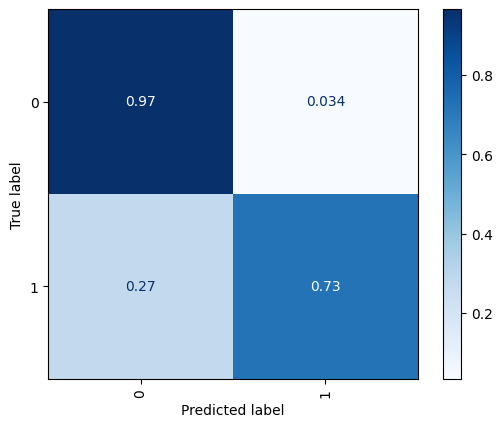

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(ytest, yhat, labels=best_rf.classes_,
                                        xticks_rotation="vertical", normalize="true",
                                        cmap=plt.cm.Blues)

XG Boost

In [ ]:
# svm
yhat = best_xgboost.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, yhat, average="macro")
print("XGBoost :")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

XGBoost :
Precision: 0.8226028797158342
Recall: 0.8328594301791648
F score: 0.8276282755272768


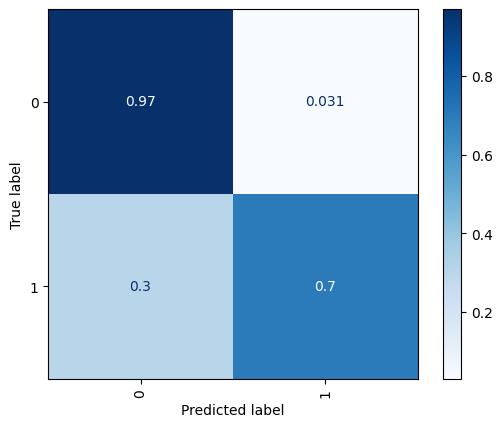

In [ ]:
ConfusionMatrixDisplay.from_predictions(ytest, yhat, labels=best_xgboost.classes_,
                                        xticks_rotation="vertical", normalize="true",
                                        cmap=plt.cm.Blues)

Random Forest on Test Set


from scipy import stats
import statsmodels.api as sm

Random Forest (Test Set):
Precision: 0.8182205607394795
Recall: 0.8459334587614349
F score: 0.8313307101646574


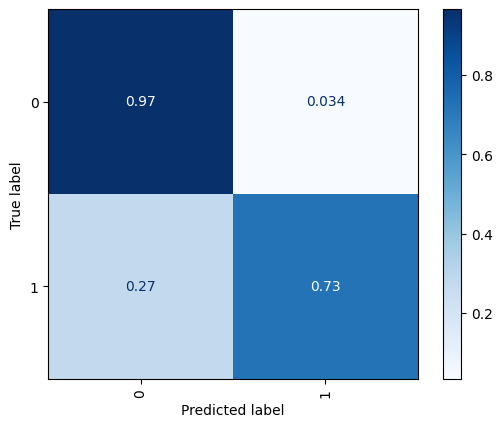

In [ ]:
# Ensure that Xtest has the same columns as Xtrain
missing_cols = set(Xtrain.columns) - set(Xtest.columns)
for col in missing_cols:
    Xtest[col] = 0  # Add the missing column with default value 0

# Reorder the columns in Xtest to match the order in Xtrain
Xtest = Xtest[Xtrain.columns]

# Now you can make predictions
yhat = best_rf.predict(Xtest)

# Calculate precision, recall, and F-score

p, r, f, s = precision_recall_fscore_support(ytest, yhat, average="macro")
print("Random Forest (Test Set):")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

ConfusionMatrixDisplay.from_predictions(ytest, yhat, labels=best_rf.classes_,
                                        xticks_rotation="vertical", normalize="true",
                                        cmap=plt.cm.Blues)


Decision Tree on Test Set

Accuracy: 0.9406
Precision: 0.8070
Recall: 0.7945
F1 Score: 0.8006


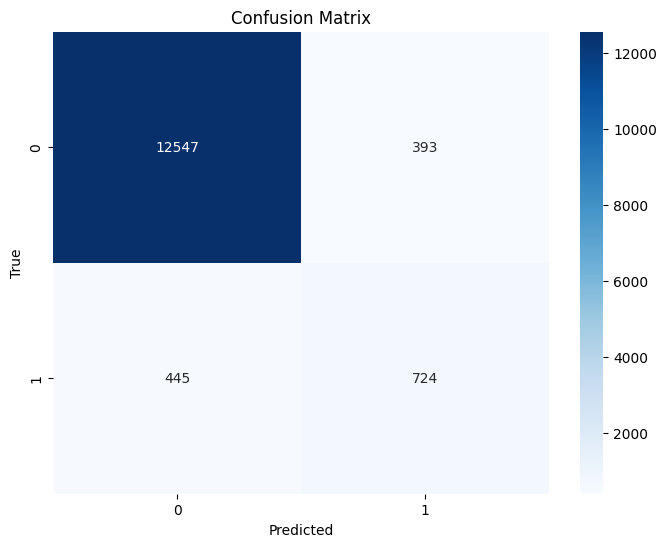


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12940
           1       0.65      0.62      0.63      1169

    accuracy                           0.94     14109
   macro avg       0.81      0.79      0.80     14109
weighted avg       0.94      0.94      0.94     14109

ROC-AUC Score: 0.8068


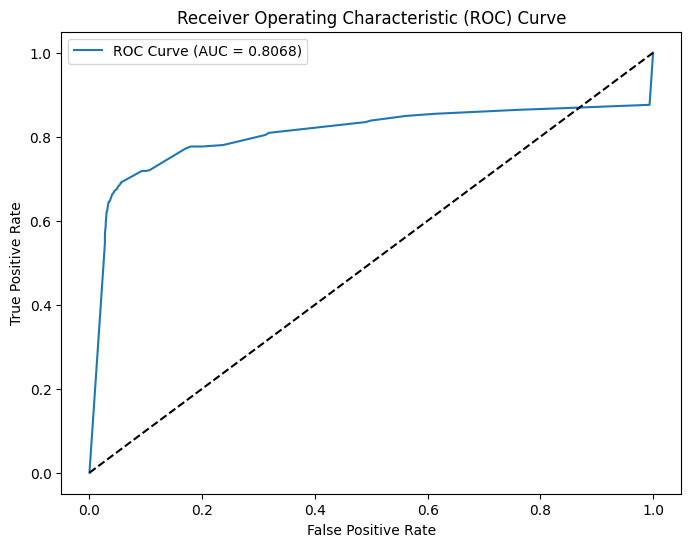

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Train the Decision Tree Classifier (as an example)
dt = DecisionTreeClassifier(max_depth=10, random_state=7)
dt.fit(Xtrain, ytrain)

# Predict on the test set
y_pred = dt.predict(Xtest)
y_proba = dt.predict_proba(Xtest)[:, 1]  # For ROC-AUC and ROC curve, get the probability scores for the positive class

# Accuracy
accuracy = accuracy_score(ytest, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(ytest, y_pred, average='macro')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(ytest, y_pred, average='macro')
print(f'Recall: {recall:.4f}')

# F1-Score
f1 = f1_score(ytest, y_pred, average='macro')
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print('\nClassification Report:')
print(classification_report(ytest, y_pred))

# ROC-AUC Score (for binary classification)
if len(set(ytest)) == 2:  # Check if it's binary classification
    roc_auc = roc_auc_score(ytest, y_proba)
    print(f'ROC-AUC Score: {roc_auc:.4f}')

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(ytest, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


Random Forest on Test Set


Accuracy: 0.9466
Precision: 0.8194
Recall: 0.8433
F1 Score: 0.8308


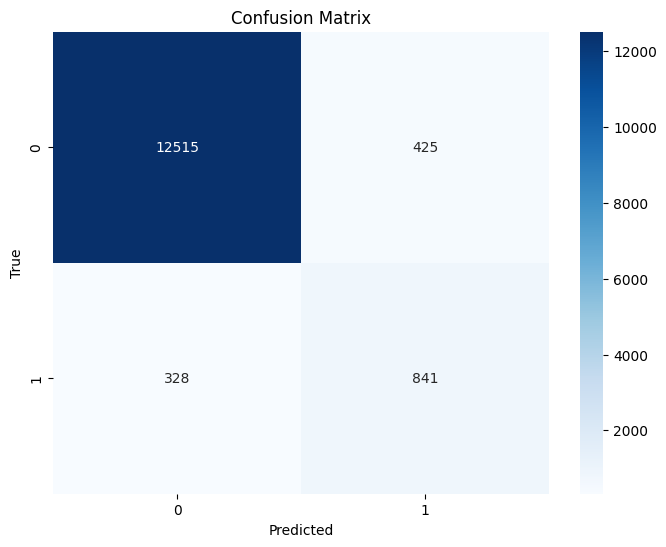


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12940
           1       0.66      0.72      0.69      1169

    accuracy                           0.95     14109
   macro avg       0.82      0.84      0.83     14109
weighted avg       0.95      0.95      0.95     14109

ROC-AUC Score: 0.8761


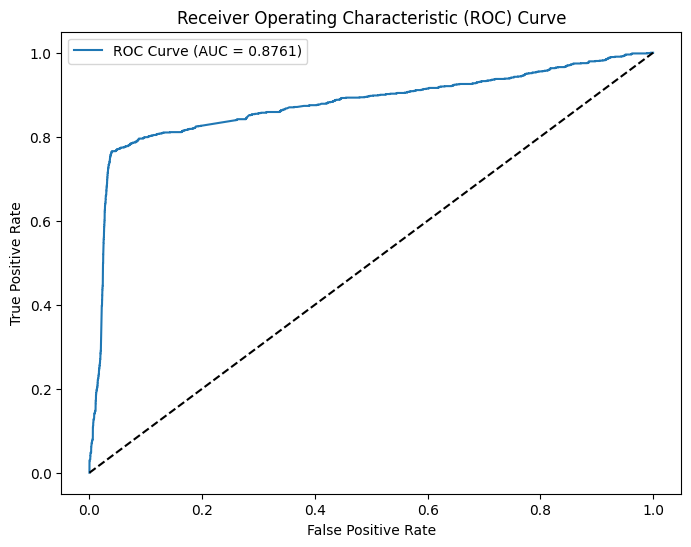

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=7)
rf.fit(Xtrain, ytrain)

# Predict on the test set
y_pred = rf.predict(Xtest)
y_proba = rf.predict_proba(Xtest)[:, 1]  # For ROC-AUC and ROC curve, get the probability scores for the positive class

# Accuracy
accuracy = accuracy_score(ytest, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(ytest, y_pred, average='macro')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(ytest, y_pred, average='macro')
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(ytest, y_pred, average='macro')
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print('\nClassification Report:')
print(classification_report(ytest, y_pred))

# ROC-AUC Score (for binary classification)
if len(set(ytest)) == 2:  # Check if it's binary classification
    roc_auc = roc_auc_score(ytest, y_proba)
    print(f'ROC-AUC Score: {roc_auc:.4f}')

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(ytest, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


XG Boost


Accuracy: 0.9444
Precision: 0.8185
Recall: 0.8125
F1 Score: 0.8155


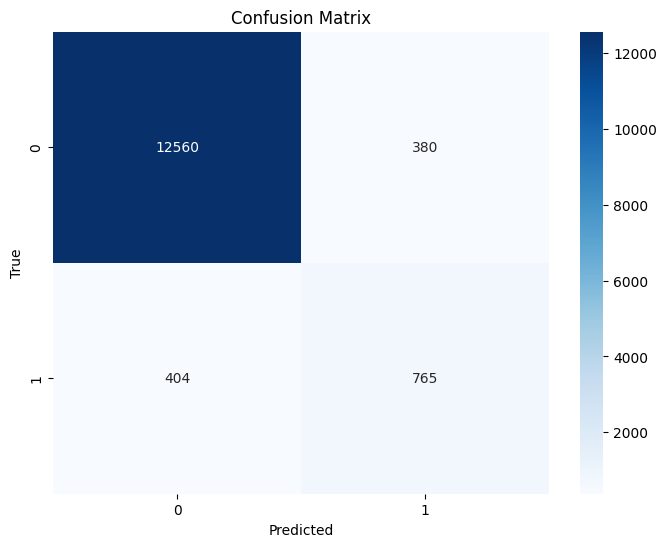


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12940
           1       0.67      0.65      0.66      1169

    accuracy                           0.94     14109
   macro avg       0.82      0.81      0.82     14109
weighted avg       0.94      0.94      0.94     14109

ROC-AUC Score: 0.9245


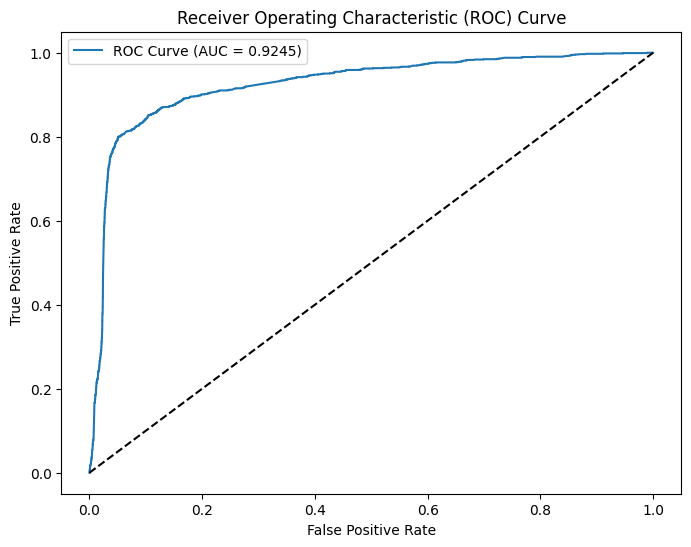

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=7, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(Xtrain, ytrain)

# Predict on the test set
y_pred = xgb_model.predict(Xtest)
y_proba = xgb_model.predict_proba(Xtest)[:, 1]  # For ROC-AUC and ROC curve, get the probability scores for the positive class

# Accuracy
accuracy = accuracy_score(ytest, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(ytest, y_pred, average='macro')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(ytest, y_pred, average='macro')
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(ytest, y_pred, average='macro')
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print('\nClassification Report:')
print(classification_report(ytest, y_pred))

# ROC-AUC Score (for binary classification)
if len(set(ytest)) == 2:  # Check if it's binary classification
    roc_auc = roc_auc_score(ytest, y_proba)
    print(f'ROC-AUC Score: {roc_auc:.4f}')

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(ytest, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


CatBoost

Accuracy: 0.9483
Precision: 0.8260
Recall: 0.8434
F1 Score: 0.8344


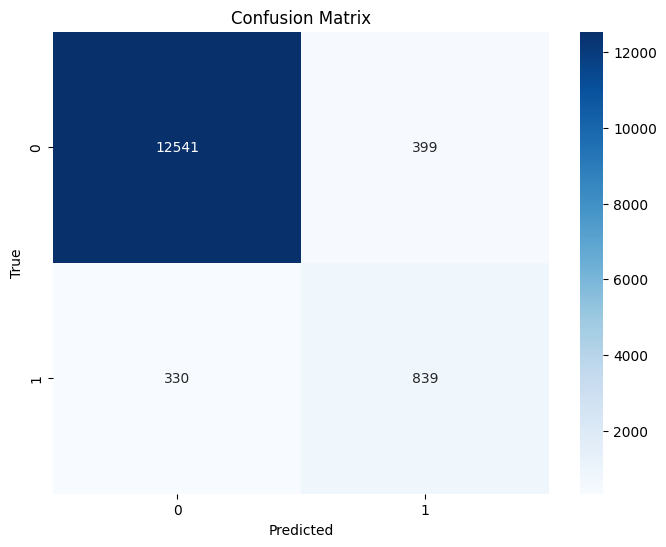


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12940
           1       0.68      0.72      0.70      1169

    accuracy                           0.95     14109
   macro avg       0.83      0.84      0.83     14109
weighted avg       0.95      0.95      0.95     14109

ROC-AUC Score: 0.9280


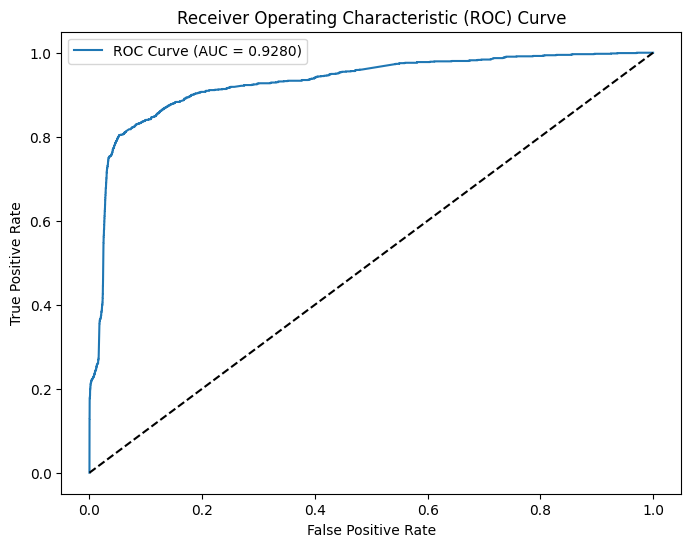

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the CatBoost Classifier
catboost_model = CatBoostClassifier(iterations=100, depth=5, learning_rate=0.1, random_state=7, verbose=0)
catboost_model.fit(Xtrain, ytrain)

# Predict on the test set
y_pred = catboost_model.predict(Xtest)
y_proba = catboost_model.predict_proba(Xtest)[:, 1]  # For ROC-AUC and ROC curve, get the probability scores for the positive class

# Accuracy
accuracy = accuracy_score(ytest, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(ytest, y_pred, average='macro')
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(ytest, y_pred, average='macro')
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(ytest, y_pred, average='macro')
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print('\nClassification Report:')
print(classification_report(ytest, y_pred))

# ROC-AUC Score (for binary classification)
if len(set(ytest)) == 2:  # Check if it's binary classification
    roc_auc = roc_auc_score(ytest, y_proba)
    print(f'ROC-AUC Score: {roc_auc:.4f}')

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(ytest, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


Plotting performance on all the models


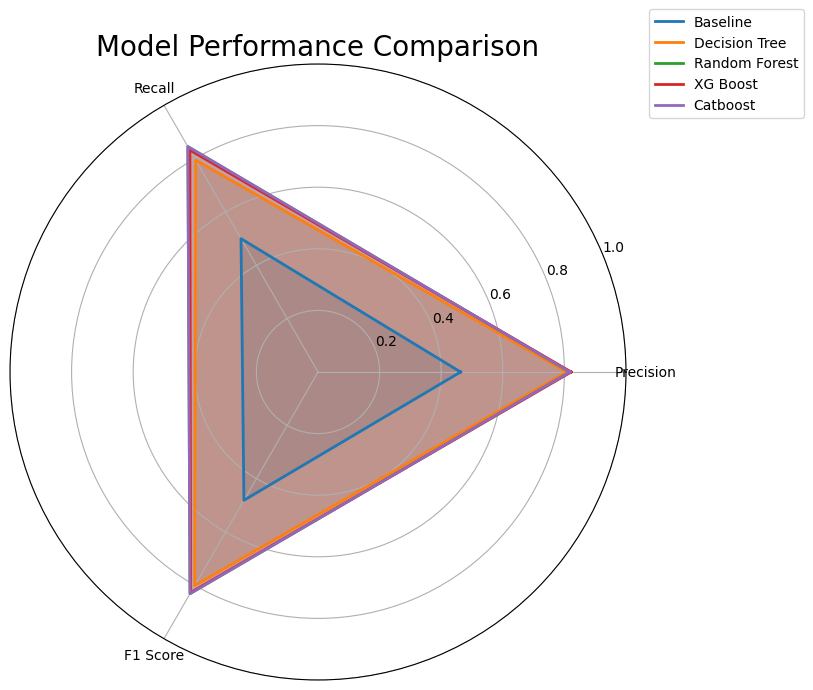

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data for radar chart
metrics = ['Precision', 'Recall', 'F1 Score']
models = ['Baseline', 'Decision Tree', 'Random Forest', 'XG Boost', 'Catboost']
values = [
    [0.463, 0.5, 0.481],       # Baseline
    [0.8070, 0.7945, 0.8006],  # Decision Tree
    [0.818, 0.845, 0.831],     # Random Forest
    [0.822, 0.832, 0.827],     # XG Boost
    [0.818, 0.845, 0.831]      # Catboost
]

# Number of variables
num_vars = len(metrics)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Make the plot a closed loop
angles += angles[:1]

# Plot radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, model_values in enumerate(values):
    # Make each model's values a closed loop
    model_values += model_values[:1]

    ax.plot(angles, model_values, label=models[i], linewidth=2)
    ax.fill(angles, model_values, alpha=0.25)

# Add labels and title
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks(angles[:-1])  # Don't repeat the last angle
ax.set_xticklabels(metrics)
ax.set_title('Model Performance Comparison', size=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


Line plot for all the models


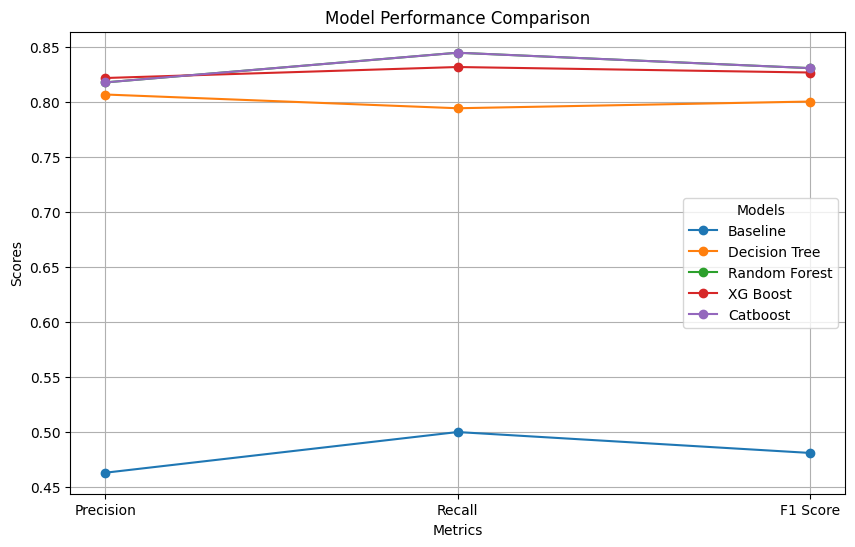

In [7]:
import matplotlib.pyplot as plt

# Data for the line plot
metrics = ['Precision', 'Recall', 'F1 Score']
models = ['Baseline', 'Decision Tree', 'Random Forest', 'XG Boost', 'Catboost']
values = {
    'Baseline': [0.463, 0.5, 0.481],
    'Decision Tree': [0.807, 0.7945, 0.8006],
    'Random Forest': [0.818, 0.845, 0.831],
    'XG Boost': [0.822, 0.832, 0.827],
    'Catboost': [0.818, 0.845, 0.831]
}

# Plotting the data
plt.figure(figsize=(10, 6))

# Loop over each model to plot its values
for model, scores in values.items():
    plt.plot(metrics, scores, marker='o', label=model)

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.legend(title='Models')
plt.grid(True)

# Show the plot
plt.show()
